# <font color="orange">AlphTech Machine Learning: RandomForest</font>

In [1]:
import pandas as pd
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('dataset.csv', encoding='utf-8')
df.columns.to_list()

['Customer_ID',
 'Customer_Name',
 'Gender',
 'Age',
 'City',
 'Bank_Name',
 'Account_Type',
 'Transaction_ID',
 'Transaction_Date',
 'Transaction_Time',
 'Transaction_Amount',
 'Merchant_ID',
 'Transaction_Type',
 'Merchant_Category',
 'Account_Balance',
 'Transaction_Device',
 'Transaction_Scope',
 'Transaction_Currency',
 'Customer_Contact',
 'Transaction_Description',
 'Customer_Email',
 'Is_Fraud']

### Categorize Transaction Time

In [3]:
# Convert the trans time into categorical data (Night, day, etc)
# timestamp and hour are helper cols only
df['timestamp'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S')
df['hour'] = df['timestamp'].dt.hour

def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(categorize_time)

# Convert to numerical for your model
df = pd.get_dummies(df, columns=['time_period'])

In [4]:
df.columns.to_list()

['Customer_ID',
 'Customer_Name',
 'Gender',
 'Age',
 'City',
 'Bank_Name',
 'Account_Type',
 'Transaction_ID',
 'Transaction_Date',
 'Transaction_Time',
 'Transaction_Amount',
 'Merchant_ID',
 'Transaction_Type',
 'Merchant_Category',
 'Account_Balance',
 'Transaction_Device',
 'Transaction_Scope',
 'Transaction_Currency',
 'Customer_Contact',
 'Transaction_Description',
 'Customer_Email',
 'Is_Fraud',
 'timestamp',
 'hour',
 'time_period_Evening',
 'time_period_Morning',
 'time_period_Night',
 'time_period_Noon']

### Drop noise cols

In [5]:
df_clean = df.drop(
    columns=[
        'Customer_ID', 
        'Customer_Name', 
        'Transaction_ID', 
        'Merchant_ID', 
        'Customer_Contact', 
        'Customer_Email', 
        'Transaction_Description',
        'Transaction_Date', 
        'Transaction_Time',
        'timestamp',
        'hour'],
    errors='ignore' 
)

### <font color="green">Feature Engineering (IMPORTANT)</font>

1. The other one is before the cleaning process
2. The "bankrupt" ratio (Behavorial): Spending $500 is normal if you have $10,000 in the bank. It is highly suspicious if you only have $510. This feature catches "account draining" fraud.
3. High transaction at night

In [6]:
def bankrupt_ratio(df):
    # add 0.01 to avoid dividing to 0
    df['amount_to_balance_ratio'] = df['Transaction_Amount'] / (df['Account_Balance'] + 0.01)
    

bankrupt_ratio(df_clean)
# print(df_clean.head())
# df_clean.columns.to_list()

In [7]:
def high_amount_night(df):
    # 1. Define "Night" (Hours < 5 AM or > 9 PM)
    is_night = (df['time_period_Night'] == True)
    
    # 2. Define "High Amount" (e.g., Top 10% of all transactions)
    # We calculate the 90th percentile dynamically
    high_threshold = df['Transaction_Amount'].quantile(0.90)
    is_high_amount = df['Transaction_Amount'] > high_threshold

    # 3. Combine: If BOTH are True, return 1. Else 0.
    df['high_amount_night'] = (is_night & is_high_amount).astype(int)

high_amount_night(df_clean)

In [8]:
df_clean.head(3)

,Gender,Age,City,Bank_Name,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Scope,Transaction_Currency,Is_Fraud,time_period_Evening,time_period_Morning,time_period_Night,time_period_Noon,amount_to_balance_ratio,high_amount_night
0,Male,60,Hue,Sacombank,Savings,16566000.0,Transfer,Restaurant,74557.27,Voice Assistant,Domestic,VND,0,False,False,False,True,222.191582,0
1,Female,51,Ho Chi Minh City,ANZ,Business,2645000.0,Bill Payment,Restaurant,74622.66,POS Mobile Device,Domestic,VND,0,True,False,False,False,35.444993,0
2,Male,20,Hue,Sacombank,Savings,17365000.0,Bill Payment,Groceries,66817.99,ATM,Domestic,VND,0,False,False,True,False,259.885061,0


In [9]:
# MOVE 'Is_Fraud' TO THE END
# Create a list of all columns except 'Is_Fraud'
cols = [col for col in df_clean.columns if col != 'Is_Fraud']

# Append 'Is_Fraud' to the end of that list
cols.append('Is_Fraud')

# Reorder the dataframe
df_clean = df_clean[cols]

df_clean.columns.to_list()

['Gender',
 'Age',
 'City',
 'Bank_Name',
 'Account_Type',
 'Transaction_Amount',
 'Transaction_Type',
 'Merchant_Category',
 'Account_Balance',
 'Transaction_Device',
 'Transaction_Scope',
 'Transaction_Currency',
 'time_period_Evening',
 'time_period_Morning',
 'time_period_Night',
 'time_period_Noon',
 'amount_to_balance_ratio',
 'high_amount_night',
 'Is_Fraud']

### LabelEncode the text cols (like City, Gender) into number for machine to understand => 1 for Male, 2 for Female

In [10]:
# 1. Create the folder if it doesn't exist
folder_name = 'encoders'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# 2. Lists of columns
text_cols = [
    'Gender', 'City', 'Bank_Name', 'Account_Type', 
    'Transaction_Type', 'Merchant_Category', 
    'Transaction_Device', 'Transaction_Scope', 'Transaction_Currency'
]

bool_cols = [
    'time_period_Evening', 'time_period_Morning', 
    'time_period_Night', 'time_period_Noon'
]

# 3. ENCODE TEXT & SAVE ENCODERS
for c in text_cols:
    le = LabelEncoder()
    # Fit and transform the data
    df_clean[c] = le.fit_transform(df_clean[c])
    
    # Save the encoder for later decode
    joblib.dump(le, os.path.join(folder_name, f'le_{c}.joblib'))

# 4. CONVERT BOOLEANS 
for c in bool_cols:
    df_clean[c] = df_clean[c].astype(int)

# print(df_clean.head())
# 1. Total counts (0 = Normal, 1 = Fraud)
print(df['Is_Fraud'].value_counts())
# Result => 5% fraud => overfitting, the model will just say 'yes its safe' for everything to get 95 accuracy
# 2. As percentages
print(df['Is_Fraud'].value_counts(normalize=True) * 100)

Is_Fraud
0    189912
1     10088
Name: count, dtype: int64
Is_Fraud
0    94.956
1     5.044
Name: proportion, dtype: float64


### Split the data into training set (80%) and testing set (20%)

In [11]:
# Seperate the Features and the Target
X = df_clean.iloc[:, 0:-1]
y = df_clean.iloc[:, -1]    # The isFraud col

# Now split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

In [12]:
print(y_test.value_counts())

Is_Fraud
0    37991
1     2009
Name: count, dtype: int64


### Using SMOTE (Synthetic Minority Over-sampling Technique) to handle imbalance in data (now the Safe >> Fraud so they won't learn anything)
<font color='red'>Only use on TRAIN DATA</font>

In [13]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled = X_resampled.round().astype(int)   # To avoid synthetic value being float like 1.5

In [14]:
print(y_resampled.value_counts())

Is_Fraud
0    151921
1    151921
Name: count, dtype: int64


### Initiate RandomForestClassifer and train the model

In [15]:
rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=15,
    min_samples_leaf=10,
    min_samples_split=20,
    n_jobs=-1,   # use all the local's cores 
    verbose=1   # Show progress
)
rf.fit(X_resampled, y_resampled)    # Training part
joblib.dump(rf, "randomForestModel.joblib") # Save for later use - when test on actual data

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished


['randomForestModel.joblib']

In [16]:
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)    # get the test core

# 1. Get probabilities instead of just 0/1
# This gives you the % chance of fraud for every row
# y_probs = rf.predict_proba(X_test)[:, 1]

# 2. Set your custom "Sensitivity"
# 0.1 means: "If there is even a 10% chance of fraud, flag it!"
# threshold = 0.4
# y_pred_new = (y_probs > threshold).astype(int)


print(score)
print(classification_report(y_test, y_pred, digits=3))  # get the report of the model
# print(classification_report(y_test, y_pred_new, digits=3))

# plt.figure(figsize=(6, 4))
# sns.heatmap(confusion_matrix(y_test, y_pred_new), annot=True, fmt='d', cmap='Blues')
# plt.title(f'Confusion Matrix (Threshold: {threshold})')
# plt.show()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


0.9015
              precision    recall  f1-score   support

           0      0.950     0.947     0.948     37991
           1      0.046     0.048     0.047      2009

    accuracy                          0.901     40000
   macro avg      0.498     0.497     0.497     40000
weighted avg      0.904     0.901     0.903     40000



[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


### Show Feature Importance (what are the features that help the machine to know fraud)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24856\1085187201.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette='viridis')


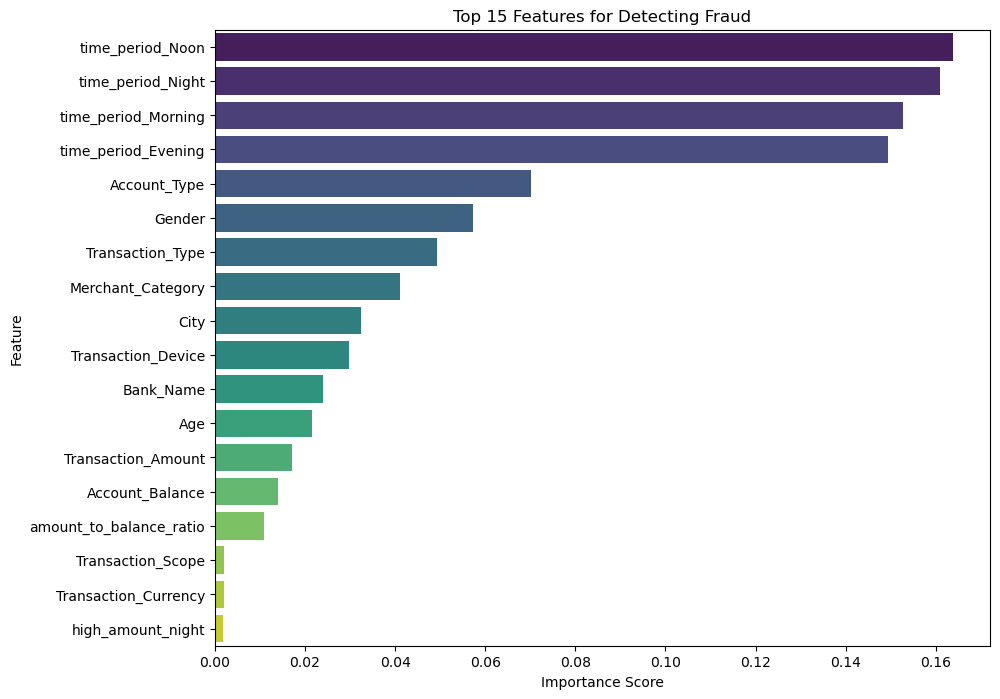

In [17]:
# 1. Get feature importances from your trained model
importances = rf.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. Plot only the Top 15 (otherwise it gets too crowded)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette='viridis')

plt.title('Top 15 Features for Detecting Fraud')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()